This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

 fix the random number seed to ensure your results are reproducible.

In [29]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [30]:
# load the dataset
dataframe = pd.read_csv('/content/drive/MyDrive/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [31]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [32]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [33]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


In [34]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [35]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [36]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
94/94 - 2s - loss: 0.0332 - 2s/epoch - 21ms/step
Epoch 2/30
94/94 - 0s - loss: 0.0143 - 178ms/epoch - 2ms/step
Epoch 3/30
94/94 - 0s - loss: 0.0109 - 179ms/epoch - 2ms/step
Epoch 4/30
94/94 - 0s - loss: 0.0098 - 178ms/epoch - 2ms/step
Epoch 5/30
94/94 - 0s - loss: 0.0089 - 195ms/epoch - 2ms/step
Epoch 6/30
94/94 - 0s - loss: 0.0078 - 323ms/epoch - 3ms/step
Epoch 7/30
94/94 - 0s - loss: 0.0070 - 358ms/epoch - 4ms/step
Epoch 8/30
94/94 - 0s - loss: 0.0062 - 317ms/epoch - 3ms/step
Epoch 9/30
94/94 - 1s - loss: 0.0056 - 523ms/epoch - 6ms/step
Epoch 10/30
94/94 - 0s - loss: 0.0049 - 493ms/epoch - 5ms/step
Epoch 11/30
94/94 - 1s - loss: 0.0043 - 580ms/epoch - 6ms/step
Epoch 12/30
94/94 - 0s - loss: 0.0038 - 466ms/epoch - 5ms/step
Epoch 13/30
94/94 - 0s - loss: 0.0034 - 449ms/epoch - 5ms/step
Epoch 14/30
94/94 - 1s - loss: 0.0031 - 589ms/epoch - 6ms/step
Epoch 15/30
94/94 - 1s - loss: 0.0028 - 669ms/epoch - 7ms/step
Epoch 16/30
94/94 - 0s - loss: 0.0026 - 484ms/epoch - 5ms/step
Epo

In [37]:
from sklearn.metrics import mean_squared_error
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 6ms/step
Train Score: 23.43 RMSE
Test Score: 48.89 RMSE


In [46]:
print("trainPredict shape:", trainPredict.shape)
print("trainY shape:", trainY.shape)
print("testPredict shape:", testPredict.shape)
print("testY shape:", testY.shape)


trainPredict shape: (94, 1)
trainY shape: (1, 94)
testPredict shape: (46, 1)
testY shape: (1, 46)


In [47]:
from sklearn.metrics import mean_squared_error

# Transpose trainY and testY to match the shape of trainPredict and testPredict
trainY = trainY.T
testY = testY.T

# Invert scaling for actual values
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

# Check shapes again to confirm they match
print("trainPredict shape:", trainPredict.shape)
print("trainY shape:", trainY.shape)
print("testPredict shape:", testPredict.shape)
print("testY shape:", testY.shape)

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))


trainPredict shape: (94, 1)
trainY shape: (94, 1)
testPredict shape: (46, 1)
testY shape: (46, 1)
Train Score: 8408042113707931.00 RMSE
Test Score: 30431069007135.70 RMSE


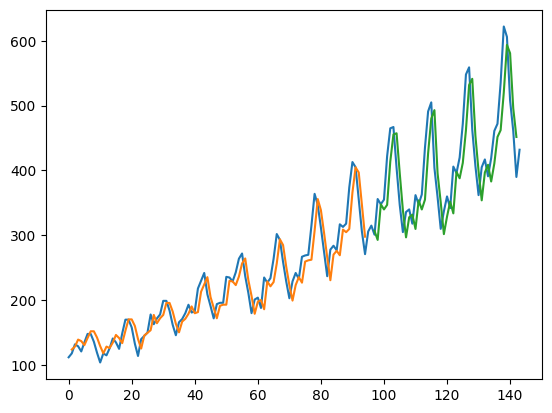

In [49]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()